In [218]:
import torch
from scipy.optimize import fsolve
from scipy.optimize import root
import traceback

import autograd.numpy as np
from autograd import jacobian


# Set variables to parsed values
n = 250.0  # Ensure float
chi = float(n)  # Ensure float
kappa = 1.0

B = 4 / (3 * np.pi)

delta = 1.0

EPS = 1e-12  # Small constant to avoid division by zero

def residual(vars, d, delta, b, n, chi, kappa, P, epsilon):
    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = vars
    lT1 = lT1_re + 1j * lT1_im
    lV1 = lV1_re + 1j * lV1_im
    lT3 = lT3_re + 1j * lT3_im
    lV3 = lV3_re + 1j * lV3_im
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = (1/d)
    TrSigma = lWT + lWP * (d - 1)
    EChh = lH1 + lH3 + ((8) / (np.pi * (1 + 2 * TrSigma)**3) * (213*lWT**3 + 9*lWT)) * (d-1) + (4 / (np.pi * (1 + 2 * TrSigma)) * lWT) * (d - 1)
    gammaYh2 = (4 / np.pi) * 1 / (1 + 2 * EChh)
    lK1 = gammaYh2 * lH1
    eq1 = lT1 - (-chi**2 / (kappa / P + lK1)**2 * delta)
    eq2 = lV1 - (1 / lJ1**2 * lH1 - 1 / lJ1)
    eq3 = lH1 - (1 / (1 / lJ1 + gammaYh2 * lT1 / (n * chi)))
    eq4 = lJ1 - (4 / (np.pi * (1 + 2 * TrSigma)) * lWT)
    lK3 = gammaYh2 * lH3
    eq5 = lT3 - (-chi**2 / (kappa / P + lK3)**2 * delta)
    eq6 = lV3 - (1 / lJ3**2 * lH3 - 1 / lJ3)
    eq7 = lH3 - (1 / (lJ3**(-1) + gammaYh2 * lT3 * epsilon**2 / (n * chi)))
    eq8 = lJ3 - ((8 ) / (np.pi * (1 + 2 * TrSigma)**3) * (213*lWT**3 + 9*lWT))
    return [
        np.real(eq1), np.imag(eq1),
        np.real(eq2), np.imag(eq2),
        np.real(eq3),
        np.real(eq4),
        np.real(eq5), np.imag(eq5),
        np.real(eq6), np.imag(eq6),
        np.real(eq7),
        np.real(eq8)
    ]

# Parallel worker: solve one initial condition
def _solve_one_init(args, eps = 0.03):
    init, d, P, χ, N = args
    try:
        sol, infodict, ier, mesg = fsolve(lambda vars: residual(vars, d, delta, B, N, χ, kappa, P, eps), init, full_output=True, xtol=1e-8)
        if ier == 1:
            residuals = np.abs(residual(sol, d, delta, B, N, χ, kappa, P, eps))
            converged = np.max(residuals) < 1e-2
            positive_definite = [(sol[4] >= 0), (sol[5] >= 0), (sol[10] >= 0), (sol[11] >= 0)]
            epsilon_close = [(np.abs(sol[4]) < 1e-10), (np.abs(sol[5]) < 1e-10), (np.abs(sol[10]) < 1e-10), (np.abs(sol[11]) < 1e-10)]
            satisfied = [p or e for p, e in zip(positive_definite, epsilon_close)]
            if converged and all(satisfied):
                return sol
            else:
                mags = [x for x in [sol[4], sol[5], sol[10], sol[11]]]
                print(f"P: {P} did not converge or was not positive definite\n: {np.max(residuals)} <?< {1e-2}\nPositive definite: {positive_definite}\n {mesg}\n\n Mags: {mags}\n")
                
    except Exception as e:
        print(e)
    return None

# Define the residual function
def residual_differentiable(vars, d, delta, b, N, χ, kappa, P, epsilon):
    # Unpack variables
    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = vars
    
    # Intermediate calculations
    # lWT = 1.0 / (d + delta * b * lV1 / N), where lV1 = lV1_re + 1j * lV1_im
    denom = d + delta * b * (lV1_re + 1j * lV1_im) / N
    denom_re = d + delta * b * lV1_re / N  # Real part of denominator
    denom_im = delta * b * lV1_im / N      # Imaginary part
    denom_mag2 = denom_re**2 + denom_im**2
    lWT_re = denom_re / denom_mag2         # Real part of 1/denom
    lWT_im = -denom_im / denom_mag2        # Imaginary part of 1/denom
    
    lWP = 1.0 / d
    TrSigma = lWT_re + lWP * (d - 1)       # TrSigma is real
    EChh = lH1 + lH3 + ((8.0 / (np.pi * (1.0 + 2.0 * TrSigma)**3)) * (213.0 * (lWT_re**3 - 3 * lWT_re * lWT_im**2) + 9.0 * lWT_re)) * (d - 1) + \
           (4.0 / (np.pi * (1.0 + 2.0 * TrSigma)) * lWT_re) * (d - 1.0)
    gammaYh2 = (4.0 / np.pi) * 1.0 / (1.0 + 2.0 * EChh)
    
    # K1 and equations for first set
    lK1 = gammaYh2 * lH1
    # eq1 = lT1 - (-χ**2.0 / (kappa / P + lK1)**2.0 * delta)
    denom_k1 = kappa / P + lK1
    denom_k1_sq = denom_k1**2
    eq1_re = lT1_re - (-χ**2.0 / denom_k1_sq * delta)
    eq1_im = lT1_im  # Since the right-hand side is real
    
    # eq2 = lV1 - (1.0 / lJ1**2 * lH1 - 1.0 / lJ1)
    eq2_re = lV1_re - (1.0 / lJ1**2 * lH1 - 1.0 / lJ1)
    eq2_im = lV1_im  # Since the right-hand side is real
    
    # eq3 = lH1 - (1.0 / (1.0 / lJ1 + gammaYh2 * lT1 / (N * χ)))
    denom_eq3 = 1.0 / lJ1 + gammaYh2 * (lT1_re + 1j * lT1_im) / (N * χ)
    denom_eq3_re = 1.0 / lJ1 + gammaYh2 * lT1_re / (N * χ)
    denom_eq3_im = gammaYh2 * lT1_im / (N * χ)
    denom_eq3_mag2 = denom_eq3_re**2 + denom_eq3_im**2
    eq3 = lH1 - (denom_eq3_re / denom_eq3_mag2)
    
    # eq4 = lJ1 - (4.0 / (np.pi * (1.0 + 2.0 * TrSigma)) * lWT)
    eq4 = lJ1 - (4.0 / (np.pi * (1.0 + 2.0 * TrSigma)) * lWT_re)
    
    # K3 and equations for second set
    lK3 = gammaYh2 * lH3
    # eq5 = lT3 - (-χ**2.0 / (kappa / P + lK3)**2.0 * delta)
    denom_k3 = kappa / P + lK3
    denom_k3_sq = denom_k3**2
    eq5_re = lT3_re - (-χ**2.0 / denom_k3_sq * delta)
    eq5_im = lT3_im  # Since the right-hand side is real
    
    # eq6 = lV3 - (1.0 / lJ3**2 * lH3 - 1.0 / lJ3)
    eq6_re = lV3_re - (1.0 / lJ3**2 * lH3 - 1.0 / lJ3)
    eq6_im = lV3_im  # Since the right-hand side is real
    
    # eq7 = lH3 - (1.0 / (lJ3**(-1) + gammaYh2 * lT3 * epsilon**2.0 / (N * χ)))
    denom_eq7 = 1.0 / lJ3 + gammaYh2 * (lT3_re + 1j * lT3_im) * epsilon**2.0 / (N * χ)
    denom_eq7_re = 1.0 / lJ3 + gammaYh2 * lT3_re * epsilon**2.0 / (N * χ)
    denom_eq7_im = gammaYh2 * lT3_im * epsilon**2.0 / (N * χ)
    denom_eq7_mag2 = denom_eq7_re**2 + denom_eq7_im**2
    eq7 = lH3 - (denom_eq7_re / denom_eq7_mag2)
    
    # eq8 = lJ3 - ((8.0) / (np.pi * (1.0 + 2.0 * TrSigma)**3) * (213.0 * lWT**3 + 9.0 * lWT))
    eq8 = lJ3 - ((8.0 / (np.pi * (1.0 + 2.0 * TrSigma)**3)) * (213.0 * (lWT_re**3 - 3 * lWT_re * lWT_im**2) + 9.0 * lWT_re))
    
    # Return residuals as a real-valued vector
    return np.array([
        eq1_re, eq1_im,
        eq2_re, eq2_im,
        eq3,
        eq4,
        eq5_re, eq5_im,
        eq6_re, eq6_im,
        eq7,
        eq8
    ])

# Compute the Jacobian
jacobian_func = jacobian(residual)

# Define fsolve functions
def fsolve_func(vars, d, delta, b, N, χ, kappa, P, epsilon):
    return residual(vars, d, delta, b, N, χ, kappa, P, epsilon)

def fsolve_jacobian(vars, d, delta, b, N, χ, kappa, P, epsilon):
    return jacobian_func(vars, d, delta, b, N, χ, kappa, P, epsilon)


def compute_lK1(sol):
    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = sol
    lV1 = lV1_re + 1j * lV1_im
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = (1/d)
    TrSigma = lWT + lWP * (d - 1)
    EChh = lH1 + lH3 + ((8.0) / (np.pi * (1 + 2 * TrSigma)**3) * (213.*lWT**3 + 9.*lWT)) * (d-1) + (4. / (np.pi * (1 + 2 * TrSigma)) * lWT) * (d - 1)
    gammaYh2 = (4.0 / np.pi) * 1.0 / (1.0 + 2.0 * EChh)
    lK1 = gammaYh2 * lH1
    return lK1

def _solve_one_init_exp(args, eps = 0.03):
    init, d, P, χ, N = args

    init = np.array(init)
    try:
        sol, info, ier, mesg = fsolve(
            lambda vars:fsolve_func(vars, d, delta, b, N, χ, kappa, P, eps), 
            init, 
            xtol=1e-8,
            # fprime=lambda vars: fsolve_jacobian(vars, d, delta, b, N, χ, kappa, P, epsilon), 
            full_output=True)

        if ier == 1:
            residuals = np.abs(fsolve_func(sol,  d, delta, b, N, χ, kappa, P, eps))
            lT1_re, lT1_im, lV1_re, lV1_im, h1, j1, lT3_re, lT3_im, lV3_re, lV3_im, h3, j3 = sol
            lH1 = np.exp(h1)
            lJ1 = np.exp(j1)
            lH3 = np.exp(h3)
            lJ3 = np.exp(j3)
            sol = np.array([lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3])
            converged = np.max(residuals) < 1e-2
            positive_definite = (sol[4] >= 0) & (sol[5] >= 0) & (sol[10] >= 0) & (sol[11] >= 0)
            if converged and positive_definite:
                return sol
            else:
                print("Did not converge or was not positive definite\n")
                print(mesg)

        else:
            print(f'Solver failed to converge: {mesg}\n')

    except Exception as e:

        print("Full error details\n")
        print(traceback.format_exc())

        return None
    return None

def rand_initial_gaussian():
    return np.array([
        np.random.normal(1e5, 1e1),     # lT1_re
        np.random.normal(1e5, 1e2),     # lT1_im
        np.random.normal(1e5, 1e2),     # lV1_re
        np.random.normal(1e5, 1e2),     # lV1_im
        np.log(np.random.normal(0.025, 0.01)), # lH1
        np.log(np.random.normal(0.025, 0.01)), # lJ1
        np.random.normal(0, 1e2),     # lT3_re
        np.random.normal(0, 1e2),     # lT3_im
        np.random.normal(1e6, 1e3),     # lV3_re
        np.random.normal(1e6, 1e3),     # lV3_im
        np.log(np.random.normal(0.025, 0.01)), # lH3
        np.log(np.random.normal(0.025, 0.01))  # lJ3
    ])

def rand_initial():
    return np.array(
        [np.random.uniform(-1e3, 1e3), # lT1_re
        np.random.uniform(-1e3, 1e3), # lT1_im
        np.random.uniform(-1e6, 1e6), # lV1_re
        np.random.uniform(-1e6, 1e6), # lV1_im
        np.random.uniform(0, 0.05), # lH1
        np.random.uniform(0, 0.05), # lJ1
        np.random.uniform(-1e3, 1e3), # lT3_re
        np.random.uniform(-1e3, 1e3), # lT3_im
        np.random.uniform(-1e6, 1e6), # lV3_re
        np.random.uniform(-1e6, 1e6), # lV3_im
        np.random.uniform(0, 0.05), # lH3
        np.random.uniform(0, 0.05) # lJ3)
        ])

def anneal(i0, d, P, N, chi0=1.0e-8, collect=False, chif=1.0):
    # Initialize the solution list with the initial condition
    current_solutions = [(chi0, i0)]
    t=0

    if chi0 == chif:
        sol = _solve_one_init((i0, d, P, chi0, N))
        if collect:
            return current_solutions+ [(chi0, sol)]
        return sol
    
    while True:
        # Compute chi_t
        chi_t =chif + (chi0 - chif) * np.exp(- 5 * t / 100)
        # print(f'chi_t: {chi_t:.8f}')

        # Get the previous solution
        _, previous_solution = current_solutions[-1]

        args = (previous_solution, d, P, chi_t, N)

        # Solve for the current chi_t
        sol = _solve_one_init(args)
        if sol is None:
            return None

        # Append the new solution
        current_solutions.append((chi_t, sol))

        # Check termination condition
        if chi_t >= chif:
            if collect:
                return current_solutions
            return current_solutions[-1][1]

        # Increment t
        t += 1

def get_lKs(sol, d, b, N, χ, kappa, P, epsilon):
    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = sol
    lV1 = lV1_re + 1j * lV1_im
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = (1/d)
    TrSigma = lWT + lWP * (d - 1)
    EChh = lH1 + lH3 + ((8) / (np.pi * (1 + 2 * TrSigma)**3) * (213*lWT**3 + 9*lWT)) * (d-1) + (4 / (np.pi * (1 + 2 * TrSigma)) * lWT) * (d - 1)
    gammaYh2 = (4 / np.pi) * 1 / (1 + 2 * EChh)
    lK1 = gammaYh2 * lH1
    lK3 = gammaYh2 * lH3
    return np.real(lK1), np.real(lK3)

In [219]:
import numpy as np
import multiprocessing as mp
from collections import defaultdict

# Assuming d, kappa, initial_conditions, anneal, and get_lKs are defined elsewhere
# N=1000
def solv(args):
    i, d, P, N, kappa = args
    # sl = anneal(i, d, P, N, 1e-8, collect=False, chif=N)
    sl = _solve_one_init((i, d, P, N, N))
    return sl, args

def sol_to_learnability(sl, args):
    i, d, P, N, kappa = args

    lK1, lK3 = get_lKs(sl,d, B, N, N, kappa, P, 0.03)
    l1 = lK1 #/ (lK1 + kappa / P)
    l3 = lK3 #/ (lK3 + kappa / P)
    return l1, l3, sl, args

def gen_initial_conditions(num_samples = 5000):
    initial_conditions = [rand_initial() for _ in range(num_samples)]
    return initial_conditions


initial_conditions = gen_initial_conditions(num_samples=10000)


alphas = np.linspace(1.4, 1.8, 3)

N_values = [1000]#sorted([2*1e5, 3*1e5,8*1e5, 1e4,2*1e4,5*1e4,8*1e4,1e6,2*1e6])
d_values = np.array([625])#np.logspace(np.log10(25), np.log10(1000), 15)
P_values = d_values ** alphas
# Prepare all tasks as (i, P, kappa) pairs
tasks = [(i, d, P, N, kappa) for d in d_values for N in N_values for P in P_values for i in initial_conditions ]

# Parallelize using 22 cores
with mp.Pool(20) as pool:
    results = [sol_to_learnability(sl,args) for sl, args in pool.imap(solv, tasks) if sl is not None]
# Organize results by P


P: 8207.899388761767 did not converge or was not positive definite
: 0.039133506152744135 <?< 0.01
Positive definite: [True, True, True, True]
 The solution converged.

 Mags: [0.04411599175273898, 0.0006320213449461633, 0.009550702125560622, 0.001266425184070896]

P: 8207.899388761767 did not converge or was not positive definite
: 0.030860435121489078 <?< 0.01
Positive definite: [True, True, True, True]
 The solution converged.

 Mags: [0.030159023691101017, 0.0006553532736096789, 0.0023372232996325213, 0.0012969726671537409]

P: 8207.899388761767 did not converge or was not positive definite
: 0.17700603529753836 <?< 0.01
Positive definite: [True, True, True, True]
 The solution converged.

 Mags: [0.01588667993132237, 0.0006013770563365377, 0.0015890716097488884, 0.003673400870366607]

P: 8207.899388761767 did not converge or was not positive definite
: 0.05135474260896444 <?< 0.01
Positive definite: [False, True, True, True]
 The solution converged.

 Mags: [-0.006769985642330797,

In [227]:
results

[(0.0032942354036024544,
  0.004017849670391988,
  array([-9.67232396e+10,  2.10189512e+00,  2.54204708e+04,  2.33436287e-05,
          8.84313437e-03,  5.70467584e-04, -6.52664363e+10,  1.42098239e+00,
          6.15340447e+03,  5.96007684e-37,  1.07856240e-02,  1.24516500e-03]),
  (array([ 3.06968538e+02,  4.85502903e+02,  9.12264542e+05, -6.87252032e+04,
           2.31662887e-03,  3.21348642e-03, -4.07697540e+00,  4.87969803e+02,
          -5.41448990e+05,  6.95910912e+05,  2.09733451e-02,  4.74368247e-02]),
   625,
   29744.59279243562,
   1000,
   1.0)),
 (0.017283368915098764,
  0.0010130935076995988,
  array([-4.22195040e+09, -4.85776035e-22,  1.02088641e+05, -6.16396176e-34,
          4.18103282e-02,  6.35081400e-04, -1.14688719e+12, -4.44763725e-21,
          7.31367347e+02,  1.20874725e-43,  2.45078215e-03,  1.27040580e-03]),
  (array([ 7.27373987e+02, -1.16843296e+02,  4.02073609e+05,  3.10443566e+05,
           4.31557174e-02,  4.42194376e-02, -9.03352540e+02, -3.09815192e

In [228]:
sl_l1 = defaultdict(list)
sl_l3 = defaultdict(list)
for r in results:
    _, d, P, N, kappa = r[3]
    l1, l3 = r[0], r[1]
    sl_l1[(d,P,N)].append(l1)
    sl_l3[(d,P,N)].append(l3)
    # l1, l3,_,d, P,N,kappa = r[3]
    # sl_l1[(P,N)].append(r[1])
    # sl_l3[(P,N)].append(r[0])



            

In [225]:
sl_l1

defaultdict(list,
            {(625, 29744.59279243562, 1000): [0.0032942354036024544,
              0.017283368915098764],
             (625, 107791.37980165744, 1000): [0.000510302935170967,
              0.0030289820564651307,
              0.0010092189500529544]})

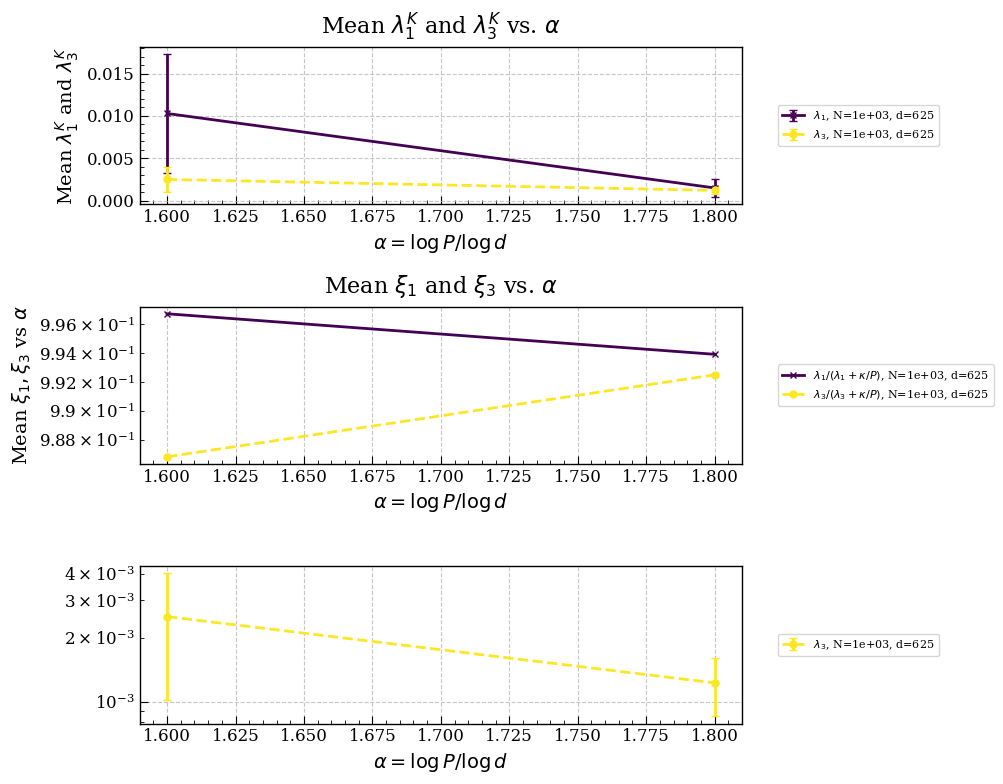

In [229]:

# Now you have dictionaries: l1s_per_P, l3s_per_P, stddevs_l1, stddevs_l3
# keyed by P values, where l1s_per_P[P] is the list of l1s for that P, etc.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import traceback  # Add this at the top if not already imported
matplotlib.rcdefaults()  # Resets all settings to their default values
# Set plot style to arXiv quality, avoiding specific font if unavailable
rcParams['font.family'] = 'serif'  # Use default serif font available on system
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 12
rcParams['figure.figsize'] = (10, 8)

# Define colormaps for each d value
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
# Define markers for each alpha value (but since alpha is continuous, we'll use different markers for different d)
markers_d = ['o', 's', '^', 'D', 'v']  # Different markers for each d
def nanrm(input_dict):
    
    return {key: value for key, value in input_dict.items() if not value.shape == 0}
# Create the plot
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

for d, P, N in sl_l1.keys():
    if len(sl_l1[(d,P,N)]) == 0 or len(sl_l3[(d, P,N)]) == 0:
        sl_l1.pop((d, P,N))
        sl_l3.pop((d, P,N))
    
for d in d_values:
    for N in N_values:
        l1s = [v for (dd, P, NN), v in sl_l1.items() if dd == d and NN == N]
        l3s = [v for (dd, P, NN), v in sl_l3.items() if dd == d and NN == N]
        Ps = [P for (dd, P, NN) in sl_l1.keys() if dd == d and NN == N]

        # Averaging over P
        l1s_per_P = defaultdict(list)
        l3s_per_P = defaultdict(list)
        for l1, l3, P in zip(l1s, l3s, Ps):
            l1s_per_P[P].extend(l1)
            l3s_per_P[P].extend(l3)

        stddevs_l1 = {P: np.std(l1s_per_P[P]) for P in l1s_per_P.keys()}
        stddevs_l3 = {P: np.std(l3s_per_P[P]) for P in l3s_per_P.keys()}
        alphas = np.log(np.array(list(l1s_per_P.keys()))) / np.log(d)

        colors = plt.cm.viridis(np.linspace(0, 1, len(l1s_per_P)))
        # Plot mean l1 with error bars
        mean_l1s = np.array([np.mean(l1s_per_P[P]) for P in l1s_per_P.keys()])
        mean_l3s = np.array([np.mean(l3s_per_P[P]) for P in l3s_per_P.keys()])
        std_l1s = np.array([stddevs_l1[P] for P in stddevs_l1.keys()])
        std_l3s = np.array([stddevs_l3[P] for P in stddevs_l3.keys()])
        ax[0].errorbar(alphas, mean_l1s, yerr=std_l1s, fmt='x-', color=colors[0], ecolor=colors[0], capsize=3, markersize=5, label=fr'$\lambda_1$, N={N:.0e}, d={d:.0f}')
        ax[0].errorbar(alphas, mean_l3s, yerr=std_l3s, fmt='o--', color=colors[-1], ecolor=colors[-1], capsize=3, markersize=5, label=fr'$\lambda_3$, N={N:.0e}, d={d:.0f}')    
        mu3s = mean_l3s / (mean_l3s + kappa / np.array(list(l3s_per_P.keys())))
        mu1s = mean_l1s / (mean_l1s + kappa / np.array(list(l1s_per_P.keys())))
        ax[1].errorbar(alphas, mu1s, fmt='x-', color=colors[0], ecolor=colors[0], capsize=3, markersize=5, label=fr'$\lambda_1 / (\lambda_1 + \kappa/P)$, N={N:.0e}, d={d:.0f}')
        ax[1].errorbar(alphas, mu3s, fmt='o--', color=colors[-1], ecolor=colors[-1], capsize=3, markersize=5, label=fr'$\lambda_3 / (\lambda_3 + \kappa/P)$, N={N:.0e}, d={d:.0f}')
        ax[2].errorbar(alphas, mean_l3s, yerr=std_l3s, fmt='o--', color=colors[-1], ecolor=colors[-1], capsize=3, markersize=5, label=fr'$\lambda_3$, N={N:.0e}, d={d:.0f}')    
        
# Customize the plot
ax[0].set_title(r'Mean $\lambda_1^K$ and $\lambda_3^K$ vs. $\alpha$', fontsize=16, pad=10)
ax[0].set_xlabel(r'$\alpha = \log P / \log d$', fontsize=14)
ax[0].set_ylabel(r'Mean $\lambda_1^K$ and $\lambda_3^K$', fontsize=14)
ax[1].set_ylabel(r'Mean $\xi_1, \xi_3$ vs $\alpha$', fontsize=14)
ax[1].set_title(r'Mean $\xi_1$ and $\xi_3$ vs. $\alpha$', fontsize=16, pad=10)
ax[1].set_xlabel(r'$\alpha = \log P / \log d$', fontsize=14)

ax[2].set_xlabel(r'$\alpha = \log P / \log d$', fontsize=14)
# Set y-axis to log scale for the second subplot
ax[1].set_yscale('log')
ax[2].set_yscale('log')

for a in ax:
    a.grid(True, linestyle='--', alpha=0.7)
    a.minorticks_on()
    # Add legend to the right (moved outside loop if legend is the same for all)
    a.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=8)

# Tight layout to prevent label clipping
plt.tight_layout()  
plt.subplots_adjust(right=0.75)  # Adjust to make space for legend
# plt.savefig(f'l1_l3_vs_alpha_by_d_legend_chi_{N}.pdf', format='pdf', dpi=300, bbox_inches='tight')

# # Customize the plot
# ax.set_xlabel(r'$\alpha = \log P / \log d$', fontsize=14)
# ax.set_ylabel(r'Mean $l_1$ and $l_3$', fontsize=14)
# ax.set_title('Mean $l_1$ and $l_3$ vs. $\\alpha$', fontsize=16, pad=10)
# ax.grid(True, linestyle='--', alpha=0.7)
# ax.minorticks_on()

# # Add legend to the right
# ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=8)

# # Tight layout to prevent label clipping
# plt.tight_layout()
# plt.subplots_adjust(right=0.75)  # Adjust to make space for legend

# # Save the plot in high quality
plt.savefig(f'l1_l3_vs_alpha_by_d_{d_values[0]}_chi_N_annealled_N_{N_values[0]}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from pympler import asizeof
asizeof.asizeof(res_dict_by_d) / 1e6
import pickle
with open(f'N0_{N_values[0]}_Nf_{N_values[-1]}_d0_{d_values[0]}_df_{d_values[-1]}_numinit_{len(initial_conditions)}.pkl', 'wb') as f:
    pickle.dump(res_dict_by_d, f)
# Example usage

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
matplotlib.rcdefaults()  # Resets all settings to their default values
# Set plot style to arXiv quality, avoiding specific font if unavailable
rcParams['font.family'] = 'serif'  # Use default serif font available on system
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 12
rcParams['figure.figsize'] = (8, 6)

# Compute means and convert P to alpha
mean_l1s = [np.mean(l1s_per_P[P]) for P in P_values]
mean_l3s = [np.mean(l3s_per_P[P]) for P in P_values]
std_l1s = [stddevs_l1[P] for P in P_values]
std_l3s = [stddevs_l3[P] for P in P_values]
alphas = np.log(P_values) / np.log(d)

# Create the plot
fig, ax = plt.subplots()

# Plot mean l1 and l3 with error bars
ax.errorbar(alphas, mean_l1s, yerr=std_l1s, fmt='-o', capsize=3, label=r'Mean $l_1$', color='blue', ecolor='blue', markersize=5)
ax.errorbar(alphas, mean_l3s, yerr=std_l3s, fmt='-s', capsize=3, label=r'Mean $l_3$', color='red', ecolor='red', markersize=5)

# Customize the plot
ax.set_xlabel(r'$\alpha = \log P / \log d$', fontsize=14)
ax.set_ylabel(r'Mean $l_1$ and $l_3$', fontsize=14)
ax.set_title('Mean $l_1$ and $l_3$ vs. $\\alpha$', fontsize=16, pad=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
ax.minorticks_on()

# Tight layout to prevent label clipping
plt.tight_layout()

# Save the plot in high quality
plt.savefig('l1_l3_vs_alpha.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 10.596342964447684

In [ ]:
def residual(vars, d, delta, b, N, χ, kappa, P, epsilon):
    # Unpack variables
    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = vars
    
    # Intermediate calculations
    # lWT = 1.0 / (d + delta * b * lV1 / N), where lV1 = lV1_re + 1j * lV1_im
    denom = d + delta * b * (lV1_re + 1j * lV1_im) / N
    denom_re = d + delta * b * lV1_re / N  # Real part of denominator
    denom_im = delta * b * lV1_im / N      # Imaginary part
    denom_mag2 = denom_re**2 + denom_im**2
    lWT_re = denom_re / denom_mag2         # Real part of 1/denom
    lWT_im = -denom_im / denom_mag2        # Imaginary part of 1/denom
    
    lWP = 1.0 / d
    TrSigma = lWT_re + lWP * (d - 1)       # TrSigma is real
    EChh = lH1 + lH3 + ((8.0 / (np.pi * (1.0 + 2.0 * TrSigma)**3)) * (213.0 * (lWT_re**3 - 3 * lWT_re * lWT_im**2) + 9.0 * lWT_re)) * (d - 1) + \
           (4.0 / (np.pi * (1.0 + 2.0 * TrSigma)) * lWT_re) * (d - 1.0)
    gammaYh2 = (4.0 / np.pi) * 1.0 / (1.0 + 2.0 * EChh)
    
    # K1 and equations for first set
    lK1 = gammaYh2 * lH1
    # eq1 = lT1 - (-χ**2.0 / (kappa / P + lK1)**2.0 * delta)
    denom_k1 = kappa / P + lK1
    denom_k1_sq = denom_k1**2
    eq1_re = lT1_re - (-χ**2.0 / denom_k1_sq * delta)
    eq1_im = lT1_im  # Since the right-hand side is real
    
    # eq2 = lV1 - (1.0 / lJ1**2 * lH1 - 1.0 / lJ1)
    eq2_re = lV1_re - (1.0 / lJ1**2 * lH1 - 1.0 / lJ1)
    eq2_im = lV1_im  # Since the right-hand side is real
    
    # eq3 = lH1 - (1.0 / (1.0 / lJ1 + gammaYh2 * lT1 / (N * χ)))
    denom_eq3 = 1.0 / lJ1 + gammaYh2 * (lT1_re + 1j * lT1_im) / (N * χ)
    denom_eq3_re = 1.0 / lJ1 + gammaYh2 * lT1_re / (N * χ)
    denom_eq3_im = gammaYh2 * lT1_im / (N * χ)
    denom_eq3_mag2 = denom_eq3_re**2 + denom_eq3_im**2
    eq3 = lH1 - (denom_eq3_re / denom_eq3_mag2)
    
    # eq4 = lJ1 - (4.0 / (np.pi * (1.0 + 2.0 * TrSigma)) * lWT)
    eq4 = lJ1 - (4.0 / (np.pi * (1.0 + 2.0 * TrSigma)) * lWT_re)
    
    # K3 and equations for second set
    lK3 = gammaYh2 * lH3
    # eq5 = lT3 - (-χ**2.0 / (kappa / P + lK3)**2.0 * delta)
    denom_k3 = kappa / P + lK3
    denom_k3_sq = denom_k3**2
    eq5_re = lT3_re - (-χ**2.0 / denom_k3_sq * delta)
    eq5_im = lT3_im  # Since the right-hand side is real
    
    # eq6 = lV3 - (1.0 / lJ3**2 * lH3 - 1.0 / lJ3)
    eq6_re = lV3_re - (1.0 / lJ3**2 * lH3 - 1.0 / lJ3)
    eq6_im = lV3_im  # Since the right-hand side is real
    
    # eq7 = lH3 - (1.0 / (lJ3**(-1) + gammaYh2 * lT3 * epsilon**2.0 / (N * χ)))
    denom_eq7 = 1.0 / lJ3 + gammaYh2 * (lT3_re + 1j * lT3_im) * epsilon**2.0 / (N * χ)
    denom_eq7_re = 1.0 / lJ3 + gammaYh2 * lT3_re * epsilon**2.0 / (N * χ)
    denom_eq7_im = gammaYh2 * lT3_im * epsilon**2.0 / (N * χ)
    denom_eq7_mag2 = denom_eq7_re**2 + denom_eq7_im**2
    eq7 = lH3 - (denom_eq7_re / denom_eq7_mag2)
    
    # eq8 = lJ3 - ((8.0) / (np.pi * (1.0 + 2.0 * TrSigma)**3) * (213.0 * lWT**3 + 9.0 * lWT))
    eq8 = lJ3 - ((8.0 / (np.pi * (1.0 + 2.0 * TrSigma)**3)) * (213.0 * (lWT_re**3 - 3 * lWT_re * lWT_im**2) + 9.0 * lWT_re))
    
    # Return residuals as a real-valued vector
    return np.array([
        eq1_re, eq1_im,
        eq2_re, eq2_im,
        eq3,
        eq4,
        eq5_re, eq5_im,
        eq6_re, eq6_im,
        eq7,
        eq8
    ])

# Compute the Jacobian
jacobian_func = jacobian(residual)

# Define fsolve functions
def fsolve_func(vars, d, delta, b, N, χ, kappa, P, epsilon):
    return residual(vars, d, delta, b, N, χ, kappa, P, epsilon)

def fsolve_jacobian(vars, d, delta, b, N, χ, kappa, P, epsilon):
    return jacobian_func(vars, d, delta, b, N, χ, kappa, P, epsilon)


def compute_lK1(sol):
    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = sol
    lV1 = lV1_re + 1j * lV1_im
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = (1/d)
    TrSigma = lWT + lWP * (d - 1)
    EChh = lH1 + lH3 + ((8.0) / (np.pi * (1 + 2 * TrSigma)**3) * (213.*lWT**3 + 9.*lWT)) * (d-1) + (4. / (np.pi * (1 + 2 * TrSigma)) * lWT) * (d - 1)
    gammaYh2 = (4.0 / np.pi) * 1.0 / (1.0 + 2.0 * EChh)
    lK1 = gammaYh2 * lH1
    return lK1

def _solve_one_init(args):
    init, d, P, χ, N = args
    init = np.array(init)
    try:
        sol, info, ier, mesg = fsolve(
            lambda vars:fsolve_func(vars, d, delta, b, N, χ, kappa, P, epsilon), 
            init, 
            maxfev = 200000,
            # fprime=lambda vars: fsolve_jacobian(vars, d, delta, b, N, χ, kappa, P, epsilon), 
            full_output=True)

        if ier == 1:
            residuals = np.abs(fsolve_func(sol,  d, delta, b, N, χ, kappa, P, epsilon))
            converged = np.max(residuals) < 1e-2
            positive_definite = (sol[4] >= 0) & (sol[5] >= 0) & (sol[10] >= 0) & (sol[11] >= 0)
            if converged and positive_definite:
                return sol
            else:
                pass
                # print('Solver failed to converge within error\n')
                # print(f'Residual: {np.max(residuals)}\n')
                # print(f'Positivity: {positive_definite}\n')
        else:
            pass
            # print(f'Solver failed to converge: {mesg}\n')

    except Exception as e:

        print("Full error details\n")
        print(traceback.format_exc())

        return None
    return None

def rand_initial():
    return np.array([
        np.random.normal(1e5, 1e1),     # lT1_re
        np.random.normal(1e5, 1e2),     # lT1_im
        np.random.normal(1e5, 1e2),     # lV1_re
        np.random.normal(1e5, 1e2),     # lV1_im
        np.random.normal(0.025, 0.01), # lH1
        np.random.normal(0.025, 0.01), # lJ1
        np.random.normal(0, 1e2),     # lT3_re
        np.random.normal(0, 1e2),     # lT3_im
        np.random.normal(1e6, 1e3),     # lV3_re
        np.random.normal(1e6, 1e3),     # lV3_im
        np.random.normal(0.025, 0.01), # lH3
        np.random.normal(0.025, 0.01)  # lJ3
    ])

def anneal(i0, d, P, N, chi0=1.0e-8, collect=False):
    # Initialize the solution list with the initial condition
    current_solutions = [(chi0, i0)]
    beta = np.log(N / chi0) / 1000
    t=0
    with tqdm(total=1000, desc=f"Annealing d={d:.0f}, P={P:.0e}") as pbar:
        while True:
            # Compute chi_t
            chi_t = chi0 * np.exp(beta * t)
            # print(f'chi_t: {chi_t:.8f}')

            # Get the previous solution
            _, previous_solution = current_solutions[-1]

            args = (previous_solution, d, P, chi_t, N)

            # Solve for the current chi_t
            sol = _solve_one_init(args)
            if sol is None:
                pbar.close()
                return None

            # Append the new solution
            current_solutions.append((chi_t, sol))

            # Check termination condition
            if chi_t >= N:
                pbar.close()
                if collect:
                    return current_solutions
                return current_solutions[-1][1]

            # Increment t
            t += 1
            pbar.update(1)

def get_lKs(sol, d):

    lT1_re, lT1_im, lV1_re, lV1_im, lH1, lJ1, lT3_re, lT3_im, lV3_re, lV3_im, lH3, lJ3 = sol
    lV1 = lV1_re + 1j * lV1_im
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = (1/d)
    TrSigma = lWT + lWP * (d - 1)
    EChh = lH1 + lH3 + ((8) / (np.pi * (1 + 2 * TrSigma)**3) * (213*lWT**3 + 9*lWT)) * (d-1) + (4 / (np.pi * (1 + 2 * TrSigma)) * lWT) * (d - 1)
    gammaYh2 = (4 / np.pi) * 1 / (1 + 2 * EChh)
    lK1 = gammaYh2 * lH1
    lK3 = gammaYh2 * lH3
    return np.real(lK1), np.real(lK3)

import numpy as np
import multiprocessing as mp
from collections import defaultdict

# Assuming d, kappa, initial_conditions, anneal, and get_lKs are defined elsewhere
# N=1000
def solv(args):
    i, d, P, N, kappa = args
    sl = anneal(i, d, P, N, chi0 = 1e-8, collect=False)
    return sl, args
def sol_to_learnability(sl, args):
    i, d, P, N, kappa = args
    lK1, lK3 = get_lKs(sl,d)
    l1 = lK1 / (lK1 + kappa / P)
    l3 = lK3 / (lK3 + kappa / P)
    return l1, l3, sl

def gen_initial_conditions(num_samples = 10000):
    initial_conditions = [rand_initial() for _ in range(num_samples)]
    return initial_conditions


initial_conditions = gen_initial_conditions(num_samples=150)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib

kappa = 1.0
alphas = np.linspace(0.1, 2.0, num=80)
N_values = [600]#sorted([2*1e5, 3*1e5,8*1e5, 1e4,2*1e4,5*1e4,8*1e4,1e6,2*1e6])
d_values = np.logspace(np.log10(25), np.log10(1000), 15)
P_values = {d: d ** alphas for d in d_values}
# Prepare all tasks as (i, P, kappa) pairs
tasks = [(i, d, P, N, kappa) for d in d_values for N in N_values for P in P_values[d] for i in initial_conditions ]

with open('/home/akiva/FCNX-Ensembling/3layerexps/erfeigensolvers/N_600_d_25.000000000000007_chi0_1e-8_num_samples150.pkl', 'rb') as f:
    res_dict_by_d = pickle.load(f)

[[[{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}]],
 [[{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}]],
 [[{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}]],
 [[{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}],
  [{}, {}, {}, {}

In [ ]:

# Now plotting

matplotlib.rcdefaults()  # Resets all settings to their default values
# Set plot style to arXiv quality, avoiding specific font if unavailable
rcParams['font.family'] = 'serif'  # Use default serif font available on system
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 12
rcParams['figure.figsize'] = (10, 8)

# Define colormaps for each d value
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
# Define markers for each alpha value (but since alpha is continuous, we'll use different markers for different d)
markers_d = ['o', 's', '^', 'D', 'v']  # Different markers for each d
def nanrm(input_dict):
    
    return {key: value for key, value in input_dict.items() if not value.shape == 0}
# Create the plot
fig, ax = plt.subplots()

# Loop through d values
for k in range(len(res_dict_by_d)):
    d = d_values[k]
    P_values_for_d = P_values[d]
    cmap_name = cmaps[k % len(cmaps)]
    marker = markers_d[k % len(markers_d)]
    try:
        res_dict_by_N = res_dict_by_d[k]
        selected_N_indices = sorted(N_values)
    except Exception as e:
        print(e)
    for idx in range(len(selected_N_indices)):
        try:
            N = sorted(N_values)[idx]
            i = sorted(N_values).index(N)

            # print([g.shape for g in res_dict_by_N])
            # Extract data for this N
            l1s_per_P, l3s_per_P, stddevs_l1, stddevs_l3 = res_dict_by_N[idx]
            mean_l1s = np.array([np.mean(l1s_per_P[P]) for P in P_values_for_d])
            mean_l3s = np.array([np.mean(l3s_per_P[P]) for P in P_values_for_d])
            std_l1s = np.array([stddevs_l1[P] for P in P_values_for_d])
            std_l3s = np.array([stddevs_l3[P] for P in P_values_for_d])
            alphas = np.log(P_values_for_d) / np.log(d)
            # print(alphas.shape)

            l1s = [l1s_per_P[P] for P in P_values_for_d]
            
                # raise(Exception)
            # print(l1s.shape)
            l3s = np.array([l3s_per_P[P] for P in l3s_per_P.keys()])
            # Get colors for this N using the d-specific colormap, different for l1 and l3
            colors_l1 = plt.cm.get_cmap(cmap_name)(np.linspace(0, 0.5, len(selected_N_indices)))
            colors_l3 = plt.cm.get_cmap(cmap_name)(np.linspace(0.5, 1, len(selected_N_indices)))
            color_l1 = colors_l1[selected_N_indices.index(N)]
            color_l3 = colors_l3[selected_N_indices.index(N)]

            # Plot mean l1 with error bars
            ax.errorbar(alphas[:mean_l1s.shape[0]], mean_l1s, yerr=std_l1s, fmt='x-', color=color_l1, ecolor=color_l1, capsize=3, markersize=5, label=fr'$\lambda_1$, N={N:.0e}, d={d:.0f}')

            ax.errorbar(alphas[:mean_l3s.shape[0]], mean_l3s, yerr=std_l3s, fmt='o--', color=color_l3, ecolor=color_l3, capsize=3, markersize=5, label=fr'$\lambda_3$, N={N:.0e}, d={d:.0f}')
        except Exception as e:
            print(e)

# Customize the plot
ax.set_xlabel(r'$\alpha = \log P / \log d$', fontsize=14)
ax.set_ylabel(r'Mean $l_1$ and $l_3$', fontsize=14)
ax.set_title('Mean $l_1$ and $l_3$ vs. $\\alpha$', fontsize=16, pad=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.minorticks_on()

# Add legend to the right
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=8)

# Tight layout to prevent label clipping
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjust to make space for legend

# Save the plot in high quality
plot_filename = f'l1_l3_vs_alpha_N_{N_values[0]}_d_{d_values[0]}_legend.pdf'
plt.savefig(plot_filename, format='pdf', dpi=300, bbox_inches='tight')
plt.show()